In [1]:
import sklearn.datasets as datasets
import numpy as np
import re
import pandas as pd
import seaborn as sns
import os
from numpy import asarray
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import scipy.stats as st
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV




## Getting our dataset

In [2]:
# Path where our data is located
base_path = "./asl_dataset/"

# Dictionary to save our 36 classes
categories = {  0: "0",
                1: "1",
                2: "2",
                3: "3",
                4: "4",
                5: "5",
                6: "6",
                7: "7",
                8: "8",
                9: "9",
                10: "a",
                11: "b",
                12: "c",
                13: "d",
                14: "e",
                15: "f",
                16: "g",
                17: "h",
                18: "i",
                19: "j",
                20: "k",
                21: "l",
                22: "m",
                23: "n",
                24: "o",
                25: "p",
                26: "q",
                27: "r",
                28: "s",
                29: "t",
                30: "u",
                31: "v",
                32: "w",
                33: "x",
                34: "y",
                35: "z",
            }

def add_class_name_prefix(df, col_name):
    df[col_name] = df[col_name].apply(
        lambda x: x[re.search("_", x).start() + 1 : re.search("_", x).start() + 2]
        + "/"
        + x
    )
    return df


# list conatining all the filenames in the dataset
filenames_list = []
# list to store the corresponding category, note that each folder of the dataset has one class of data
categories_list = []

for category in categories:
    filenames = os.listdir(base_path + categories[category])
    filenames_list = filenames_list + filenames
    categories_list = categories_list + [category] * len(filenames)

df = pd.DataFrame({"filename": filenames_list, "category": categories_list})
df = add_class_name_prefix(df, "filename")

# Shuffle the dataframe
df = df.sample(frac=1).reset_index(drop=True)

In [3]:
# current display of the dataframe
df.head()

,filename,category
0,9/hand1_9_bot_seg_4_cropped.jpeg,9
1,8/hand4_8_bot_seg_2_cropped.jpeg,8
2,p/hand2_p_bot_seg_3_cropped.jpeg,25
3,o/hand2_o_left_seg_1_cropped.jpeg,24
4,c/hand5_c_dif_seg_5_cropped.jpeg,12


In [4]:
# Display the number of images in each class
freq = {}
for cat in df["category"].unique():
    for val in df["category"]:
        if val == cat:
            if cat not in freq:
                freq[cat] = 1
            else:
                freq[cat] += 1
freq.keys()
freq.values()

dict_values([70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 65, 70, 70])

In [5]:
# Load the images and convert them to numpy arrays
pixel_arrays = []
for i,img in enumerate(df["filename"]):
    img = Image.open(base_path+img)  
    numpydata = asarray(img)
    pixel_arrays.append(numpydata)
df["pixel_data"] = pixel_arrays

In [6]:
# Display the image resolution
df["pixel_data"][0].shape

(400, 400, 3)

In [7]:
# current display of the dataframe after adding the pixel data
df.head()

,filename,category,pixel_data
0,9/hand1_9_bot_seg_4_cropped.jpeg,9,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
1,8/hand4_8_bot_seg_2_cropped.jpeg,8,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
2,p/hand2_p_bot_seg_3_cropped.jpeg,25,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
3,o/hand2_o_left_seg_1_cropped.jpeg,24,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
4,c/hand5_c_dif_seg_5_cropped.jpeg,12,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."


In [ ]:
# function to create a mask for the hand in the image
def get_mask(color_hand_image, v=30):
    """
    This function only works for colored images. It is a fast function that works for our dataset.
    For external photos and predicitons we will use a more complex function.
    """
    # Calculate the most popular color in the first 20 pixels of the first row
    bg = color_hand_image[0, :20]
    popular_color = st.mode(bg, axis=0).mode[0]
    
    # Define high and low thresholds 
    high_cota = np.clip(popular_color + v, 0, 255)
    low_cota = np.clip(popular_color - v, 0, 255)
    
    # Create the mask using numpy
    mask = np.all((color_hand_image >= low_cota) & (color_hand_image <= high_cota), axis=-1)
    return np.uint8(~mask)  # transfrom mask to uint8 



In [9]:
# Create the masks for each image, applying the function above
masks = []
for data in df["pixel_data"]:
    m = get_mask(data)
    masks.append(m)

df["masks"] = masks

In [10]:
# Convert the pixel data to grayscale
gray_scale = []
for data in df["pixel_data"]:
    gray_data = data.mean(axis=2)
    gray_scale.append(gray_data.astype(np.uint8))

df["pixel_data"] = gray_scale


In [11]:
# current display of the dataframe after adding the masks and converting the pixel data to grayscale
df.head()

,filename,category,pixel_data,masks
0,9/hand1_9_bot_seg_4_cropped.jpeg,9,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,8/hand4_8_bot_seg_2_cropped.jpeg,8,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,p/hand2_p_bot_seg_3_cropped.jpeg,25,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,o/hand2_o_left_seg_1_cropped.jpeg,24,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,c/hand5_c_dif_seg_5_cropped.jpeg,12,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


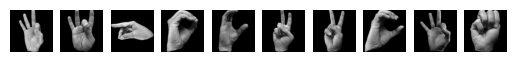

In [12]:
# visualizing the first 10 images in grayscale
for i in range(10): 
    plt.subplot(1, 10, i+1)
    plt.imshow(df["pixel_data"].iloc[i], cmap='gray')
    plt.axis('off')
plt.show()

## Extracting the keypoints

In [13]:
# Function to generate a dense grid of keypoints
def generate_dense_keypoints(image,mask, step_size=8):
    """
    This function takes all the pixels in the image and takes keypoints for every step_size pixels which are in the mask.
    """
    h, w = image.shape
    dense_keypoints = [
        cv2.KeyPoint(x, y, step_size) 
        for y in range(0, h, step_size) 
        for x in range(0, w, step_size)
        if mask[y][x] == 1
    ]
    return dense_keypoints

In [14]:
sift = cv2.SIFT_create()

keypoints = []
descriptors = []

In [15]:
# Generate and compute the keypoints and descriptors for each image
for i,img in enumerate(df["pixel_data"]):
    mask = df["masks"][i]
    dense_kp = generate_dense_keypoints(img,mask)
    
    _, des = sift.compute(img, dense_kp)
    
    keypoints.append(dense_kp)
    descriptors.append(des)

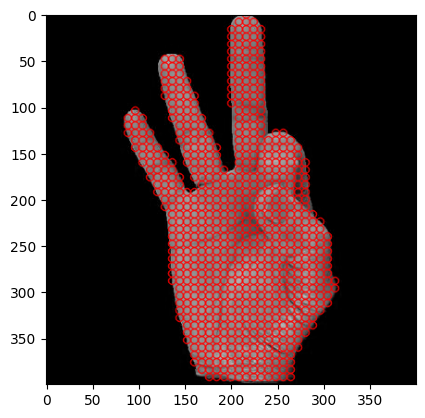

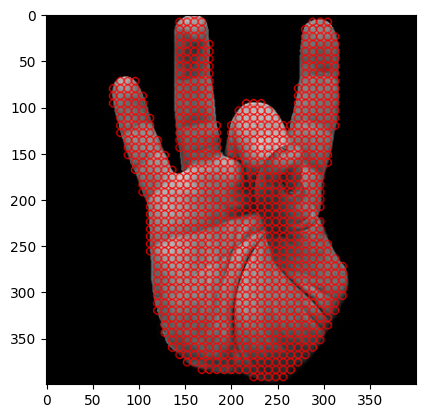

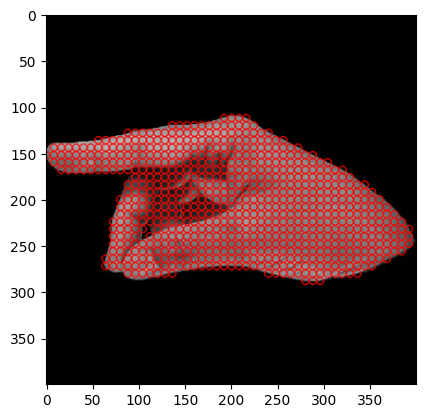

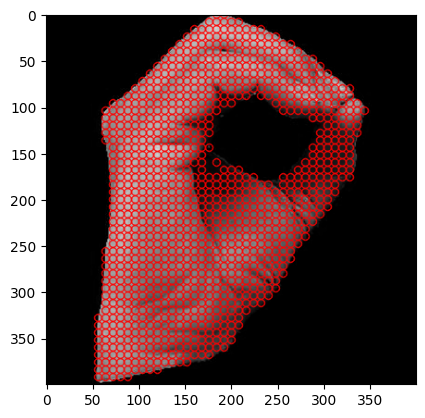

In [16]:
# visualizing the keypoints for the first 4 images
output_image = []
for x in range(4):
    output_image.append(cv2.drawKeypoints(df["pixel_data"][x], keypoints[x], 0, (255, 0, 0),
                                 flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS))
    plt.imshow(output_image[x], cmap='gray')
    plt.show()

## The Codebook

In [19]:
# Concatenate all descriptors 
all_descriptors = []
for img_descriptors in descriptors:
    if img_descriptors is not None:  
        all_descriptors.extend(img_descriptors)

all_descriptors = np.stack(all_descriptors)

In [20]:
np.random.seed(0)

sample_idx = np.random.randint(0, len(df)+1, 1000).tolist()
descriptors_sample = []

# We get the descriptors of 1000 random shapes to establish the codebook
for n in sample_idx: 
    descriptors_sample.append(np.array(descriptors[n]))

In [21]:
print("Final descriptor shape: ",all_descriptors.shape)

Final descriptor shape:  (2386893, 128)


## Kmeans

In [22]:
k = 200  # number of clusters
iters = 1  

# We create the codebook using the clusters of the trained kmeans
kmeans = KMeans(n_clusters=k, n_init=iters, max_iter=300, random_state=0)
kmeans.fit(all_descriptors)

codebook = kmeans.cluster_centers_
variance = kmeans.inertia_

## SVM

In [23]:
# We create the histogram of the features of each image using the codebook
im_features = np.zeros((len(df["pixel_data"]), k), dtype=np.float32)
for i, img_descriptors in enumerate(descriptors):
    if img_descriptors is not None:
        for feature in img_descriptors:
            feature = feature.reshape(1, -1)
            idx = kmeans.predict(feature)
            im_features[i][idx] += 1

KeyboardInterrupt: 

In [ ]:
# using the normalized data, we train the BASIC SVM model
scaler = StandardScaler().fit(im_features)
im_features = scaler.transform(im_features)


x_train, x_test, y_train, y_test = train_test_split(im_features, df["category"],train_size=0.5,shuffle=True,random_state=25)

svm = SVC(kernel='linear', C=1.0, gamma='scale')
svm.fit(x_train, y_train)


SVC(kernel='linear')

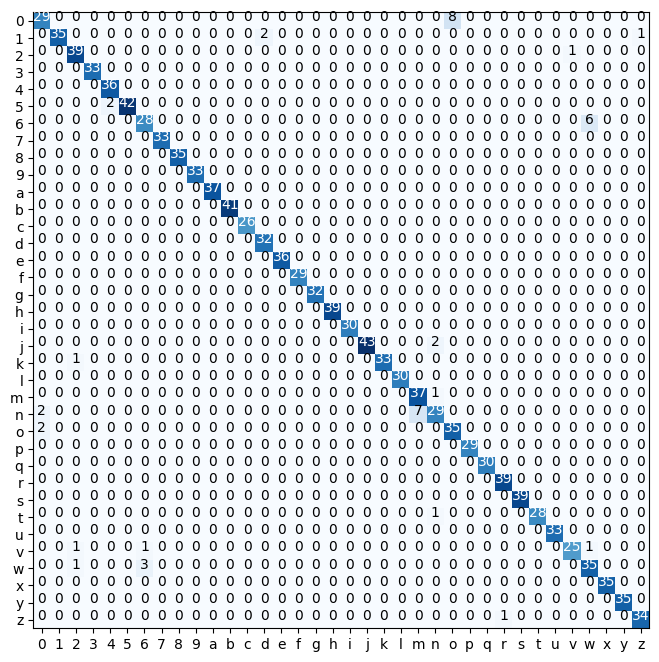

In [ ]:
# visualization of the predction results using a confusion matrix
y_pred = svm.predict(x_test)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 8))

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2.0 else "black")
plt.xticks(np.array([i for i in range(cm.shape[0])]),categories.values())
plt.yticks(np.array([i for i in range(cm.shape[0])]),categories.values())

plt.show()


In [ ]:
print("Classification report:")
print(classification_report(y_test, y_pred))

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.88      0.78      0.83        37
           1       1.00      0.92      0.96        38
           2       0.93      0.97      0.95        40
           3       1.00      1.00      1.00        33
           4       0.95      1.00      0.97        36
           5       1.00      0.95      0.98        44
           6       0.88      0.82      0.85        34
           7       1.00      1.00      1.00        33
           8       1.00      1.00      1.00        35
           9       1.00      1.00      1.00        33
          10       1.00      1.00      1.00        37
          11       1.00      1.00      1.00        41
          12       1.00      1.00      1.00        26
          13       0.94      1.00      0.97        32
          14       1.00      1.00      1.00        36
          15       1.00      1.00      1.00        29
          16       1.00      1.00      1.00        32
 

In [ ]:
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.3f}")

Accuracy: 0.965


### SVM using GridSearchCV

In [ ]:
# we use GridSearchCV to find the best hyperparameters for the SVM model
svm = SVC()


param_grid = {
    'C': [0.1, 1, 10, 100],              # regularization parameter
    'gamma': ['scale', 'auto', 0.1, 1],  # gamma
    'kernel': ['linear', 'rbf', 'poly']  # kernel
}

grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

grid_search.fit(x_train, y_train)

print("Best hyperparameters:")
print(grid_search.best_params_)


Mejores parámetros encontrados:
{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


In [ ]:
# We use the best model to predict the test data
best_model = grid_search.best_estimator_
y_pred = best_model.predict(x_test)

print("Reporte de clasificación:")
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.94      0.86      0.90        37
           1       1.00      0.92      0.96        38
           2       0.91      0.97      0.94        40
           3       1.00      1.00      1.00        33
           4       0.97      1.00      0.99        36
           5       1.00      0.98      0.99        44
           6       0.97      0.85      0.91        34
           7       1.00      1.00      1.00        33
           8       1.00      0.91      0.96        35
           9       0.92      1.00      0.96        33
          10       1.00      1.00      1.00        37
          11       1.00      1.00      1.00        41
          12       1.00      1.00      1.00        26
          13       0.94      1.00      0.97        32
          14       1.00      1.00      1.00        36
          15       1.00      1.00      1.00        29
          16       1.00      1.00      1.00        32
 

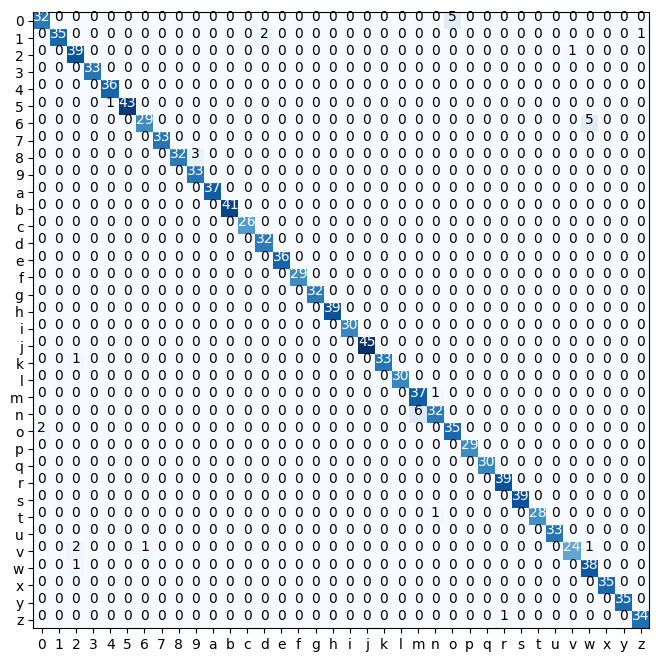

In [ ]:
# we visualize the predictions using a confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 8))

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2.0 else "black")
plt.xticks(np.array([i for i in range(cm.shape[0])]),categories.values())
plt.yticks(np.array([i for i in range(cm.shape[0])]),categories.values())

plt.show()


In [ ]:
def get_mask_color_grayscale(hand_image,v=30):
    """
    This function uses the same logic as the get_mask function but for grayscale images.
    This code is slower, but works better when the image is in grayscale.
    """
    bg = np.array(hand_image[0][:20])
    analysis = st.mode(bg)
    
    # Find the most popular color in the first 20
    popular_color = analysis.mode

    mask = np.ones((hand_image.shape[0],hand_image.shape[1]),dtype=np.uint8)
    
    high_cota = min(255,popular_color+v)
    low_cota = max(0,popular_color-v)

    for y,row in enumerate(hand_image):
        for x,px in enumerate(row):
            if (px<=high_cota) and (px>=low_cota):
                mask[y][x] = 0
                
    return mask

In [ ]:
def predict_image(img_path,normalizer=scaler,km=kmeans,best_model=best_model):
    
    img = Image.open(img_path)  
    numpydata = asarray(img)
    
    mask = get_mask(numpydata)
    
    if len(numpydata.shape)==3:
        gray_data = numpydata.mean(axis=2)
        gray_data = gray_data.astype(np.uint8)
    else:
        gray_data = numpydata.astype(np.uint8)


    plt.imshow(mask)
    dense_kp = generate_dense_keypoints(gray_data,mask)
    
    # Compute descriptors at dense keypoints
    _, des = sift.compute(gray_data, dense_kp, mask)

    im_features = np.zeros(k, dtype=np.float32)
    
    if des is not None:
        for feature in des:
            feature = feature.reshape(1, -1)
            idx = km.predict(feature)
            im_features[idx] += 1
    
    im_features = normalizer.transform(im_features.reshape(1,-1))

    y_pred = best_model.predict(im_features)
    
    return categories[y_pred[0]]


IndexError: index 1 is out of bounds for axis 0 with size 1

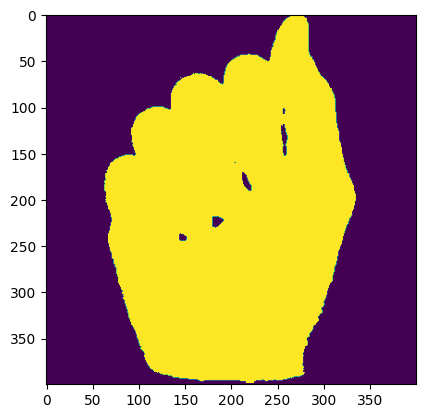

In [ ]:
# Test 1: Predicting an image with the letter "a" signed
predict_image("asl_dataset/a/hand1_a_bot_seg_1_cropped.jpeg") # THIS PATH WONT WORK, change it to the desired image path

'b'

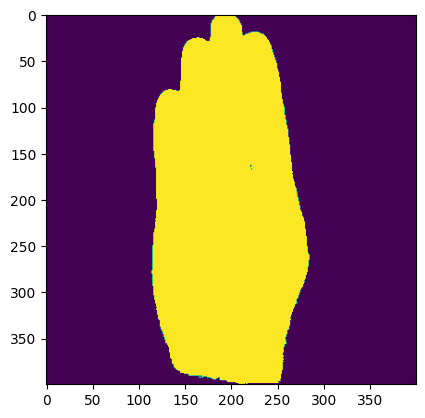

In [ ]:
# Test 2: Predicting an image with the letter "b" signed
predict_image("asl_dataset/b/hand1_b_bot_seg_1_cropped.jpeg") # THIS PATH WONT WORK, change it to the desired image path

'c'

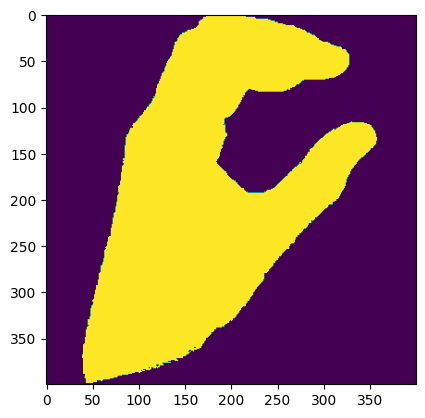

In [ ]:
# Test 3: Predicting an image with the letter "c" signed
predict_image("asl_dataset/c/hand1_c_bot_seg_1_cropped.jpeg") # THIS PATH WONT WORK, change it to the desired image path

'd'

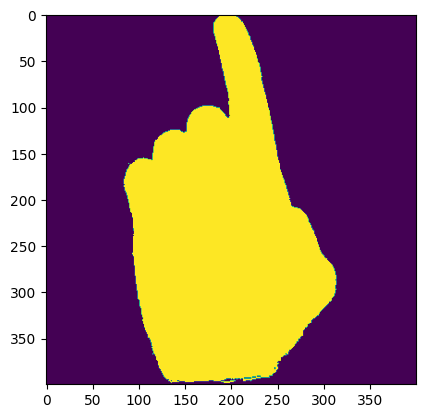

In [ ]:
# Test 4: Predicting an image with the letter "d" signed
predict_image("asl_dataset/d/hand1_d_bot_seg_2_cropped.jpeg") # THIS PATH WONT WORK, change it to the desired image path

'e'

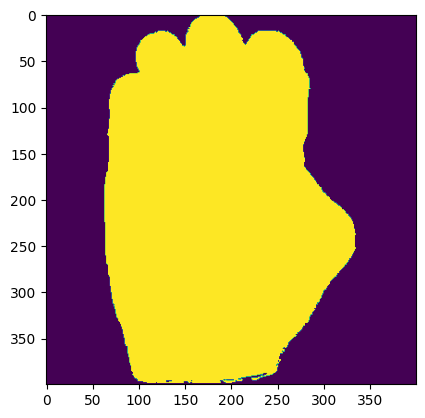

In [ ]:
# Test 5: Predicting an image with the letter "e" signed
predict_image("asl_dataset/e/hand1_e_bot_seg_1_cropped.jpeg") # THIS PATH WONT WORK, change it to the desired image path

'u'

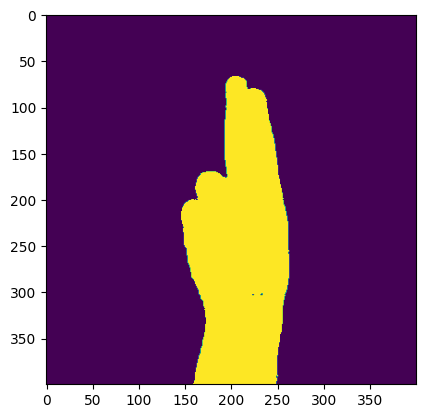

In [ ]:
# Test 6: Trying to predict a processed frame from the video signing the letter "u"
predict_image("Images/Results/frame64.jpg_processed.png") # THIS PATH WONT WORK FOR YOU

### Frame Classification

['u', 'u', 'f', 'u', 'u', 'u', 'u', 'u', 'u', 'u', 'u', 'u', 'u', 'u', 'u', 'u', 'u', 'u', 'u', 'u', 'u', 'r', 'u', 'u', 'u', 'u', 'r', 'r', 'u', 'u', 'u', 'u', 'u', 'u', 'u', 'u', 'u', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'd', 'd', 'd', 'd', 'd', '1', 'd', '1', '1', '1', '1', '1', '1', 'd', '1', 'd', '1', 'd', '1', '1', '1', '1']


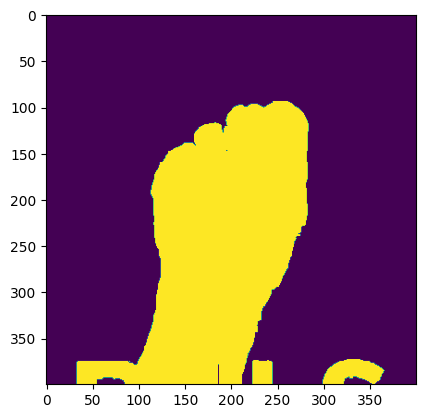

In [ ]:
frames_pred= []
for i in range(1,200):
    try:
        frames_pred.append(predict_image(f"Images/Results/frame{i}.jpg_processed.png",scaler,kmeans,best_model)) # THIS PATH WONT WORK FOR YOU
    except:
        pass
print(frames_pred)